In [ ]:
from google.colab import files

uploaded = files.upload()

Saving DCGAN.zip to DCGAN.zip


In [ ]:
import zipfile
import os

In [ ]:
with zipfile.ZipFile("/content/DCGAN.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
input_folder = '/content/data_faces'

In [ ]:
splitfolders.ratio(input_folder, output='/content/data', seed=42, 
                   ratio=(.7,.2, .1), group_prefix=None)

Copying files: 1289 files [00:00, 5179.48 files/s]


In [ ]:
splitfolders.fixed(input_folder, output='/content/data', seed=42, 
                   fixed=(35, 20), oversample=False, group_prefix=None)

Copying files: 1289 files [00:00, 2657.31 files/s]


In [ ]:
import numpy as np
from collections import OrderedDict
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from functools import reduce
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
%config InlineBackend.figure_format = 'retina'
train_on_gpu = torch.cuda.is_available()

In [ ]:
def DataConstructor2000(path_to_train, path_to_test, classes=None, num_workers=4, batch_size=12, valid_size = 0.2):
    
  
    # Transformations to the image, edit as need be
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize([299,299]),
        transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(path_to_train, transform=transform)
    print("Successfully Loaded Training Set.")

    test_dataset = datasets.ImageFolder(path_to_test, transform=transform)
    print("Successfully Loaded Test Set.")

    
    # obtain training indices that will be used for validation
    num_train = len(train_dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=6, 
        num_workers=num_workers, shuffle=True)
    if classes != None:
        print("Number of Classes:", len(classes))
    return train_loader, valid_loader, test_loader, classes

In [ ]:
train_loader, valid_loader,test_loader, classes = DataConstructor2000(path_to_train='/content/data/train',path_to_test='/content/data/test',
                                                                       classes=['Fake','Real'],num_workers=40, batch_size=16, valid_size = 0.3)

Successfully Loaded Training Set.
Successfully Loaded Test Set.
Number of Classes: 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x


class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.relu3 = nn.ReLU(inplace=True)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)

        # #------- init weights --------
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #     elif isinstance(m, nn.BatchNorm2d):
        #         m.weight.data.fill_(1)
        #         m.bias.data.zero_()
        # #-----------------------------

    def features(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        return x

    def logits(self, features):
        x = nn.ReLU(inplace=True)(features)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def xception(num_classes=2):
    model = Xception(num_classes=num_classes)
    # TODO: ugly
    model.last_linear = model.fc
    del model.fc
    return model.cuda()

In [ ]:
model = xception(num_classes=2)
model = nn.DataParallel(model)

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optimizer = torch.optim.SGD([
    {'params': list(model.parameters())[:-1], 'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-3},
    {'params': list(model.parameters())[-1], 'lr': 5e-5, 'momentum': 0.9, 'weight_decay': 1e-5}
])

In [ ]:
# number of epochs to train the model
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss
training_vis = []
valid_vis = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    training_vis.append(train_loss)
    valid_vis.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\nValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'Xception35656_gan-detector_Final.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.426721 	Validation Loss: 0.308307

Validation loss decreased (inf --> 0.308307).  Saving model ...
Epoch: 2 	Training Loss: 0.266397 	Validation Loss: 0.326190
Epoch: 3 	Training Loss: 0.254303 	Validation Loss: 0.171697

Validation loss decreased (0.308307 --> 0.171697).  Saving model ...
Epoch: 4 	Training Loss: 0.146490 	Validation Loss: 0.070804

Validation loss decreased (0.171697 --> 0.070804).  Saving model ...
Epoch: 5 	Training Loss: 0.112248 	Validation Loss: 0.071502
Epoch: 6 	Training Loss: 0.086559 	Validation Loss: 0.089029
Epoch: 7 	Training Loss: 0.049498 	Validation Loss: 0.052832

Validation loss decreased (0.070804 --> 0.052832).  Saving model ...
Epoch: 8 	Training Loss: 0.083268 	Validation Loss: 0.046280

Validation loss decreased (0.052832 --> 0.046280).  Saving model ...
Epoch: 9 	Training Loss: 0.044441 	Validation Loss: 0.028394

Validation loss decreased (0.046280 --> 0.028394).  Saving model ...
Epoch: 10 	Training Loss: 0.044356 	

In [ ]:
# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load('Xception35656_gan-detector_Final.pt'))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
#     print(target)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
#     print(output)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
#     print(pred)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(2):
#         print(i)
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.130759

Test Accuracy of  Fake: 87% (21/24)
Test Accuracy of  Real: 95% (19/20)

Test Accuracy (Overall): 90% (40/44)


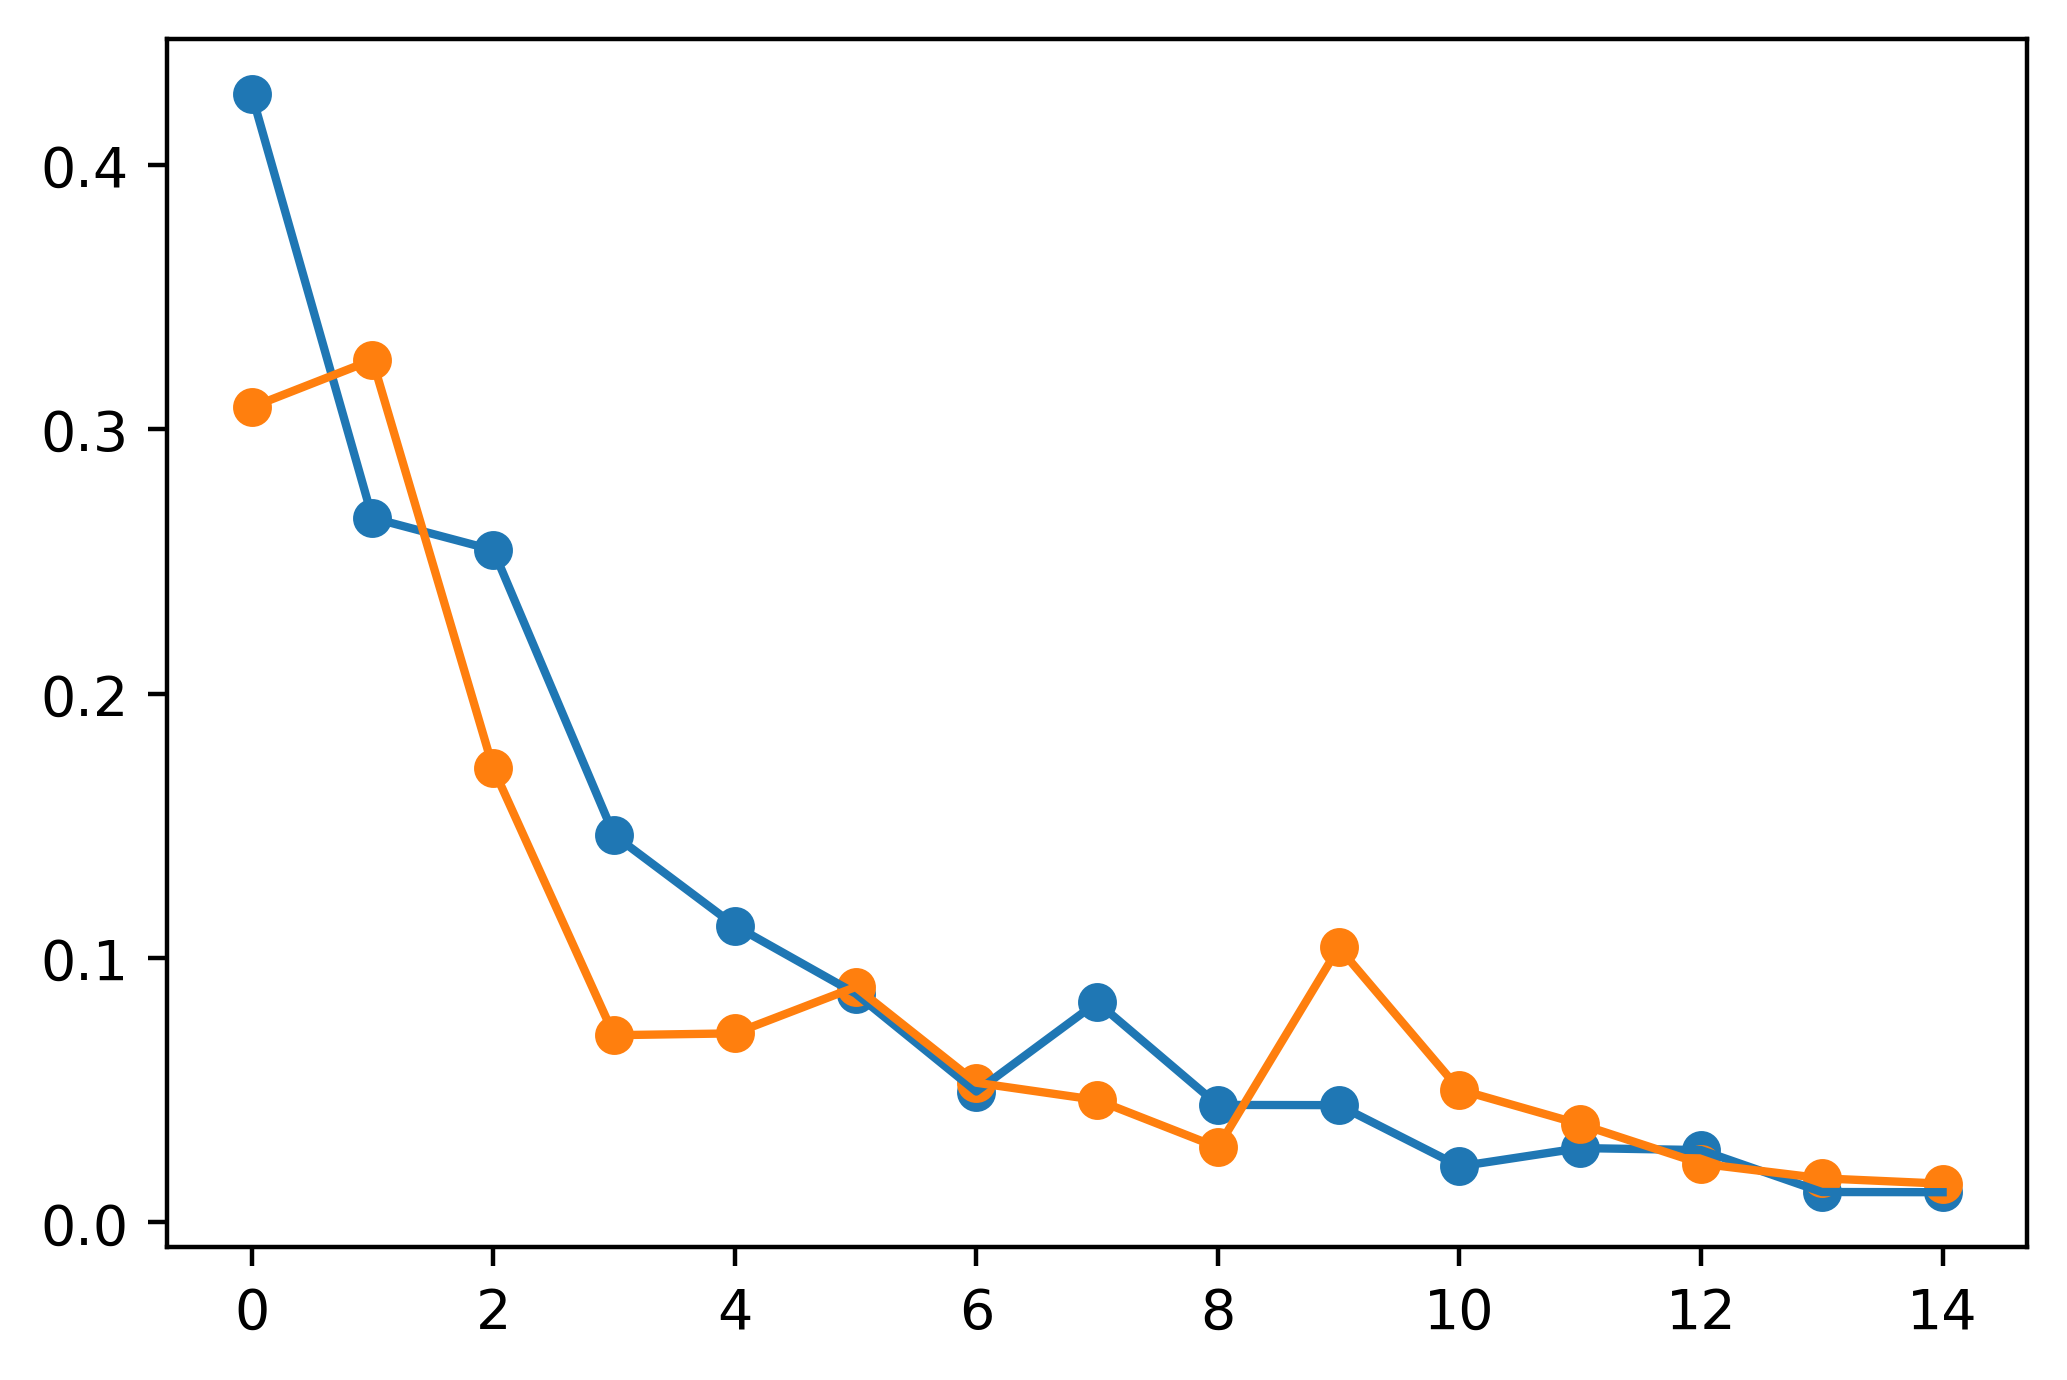

In [ ]:
plt.plot(range(epoch), training_vis)
plt.scatter(range(epoch), training_vis)
plt.scatter(range(epoch), valid_vis)
plt.plot(range(epoch), valid_vis)
plt.savefig('Xception_line.svg')

In [ ]:
np.savetxt('Xception_85.txt', np.array([training_vis, valid_vis]))

(6, 3, 299, 299)


IndexError: ignored

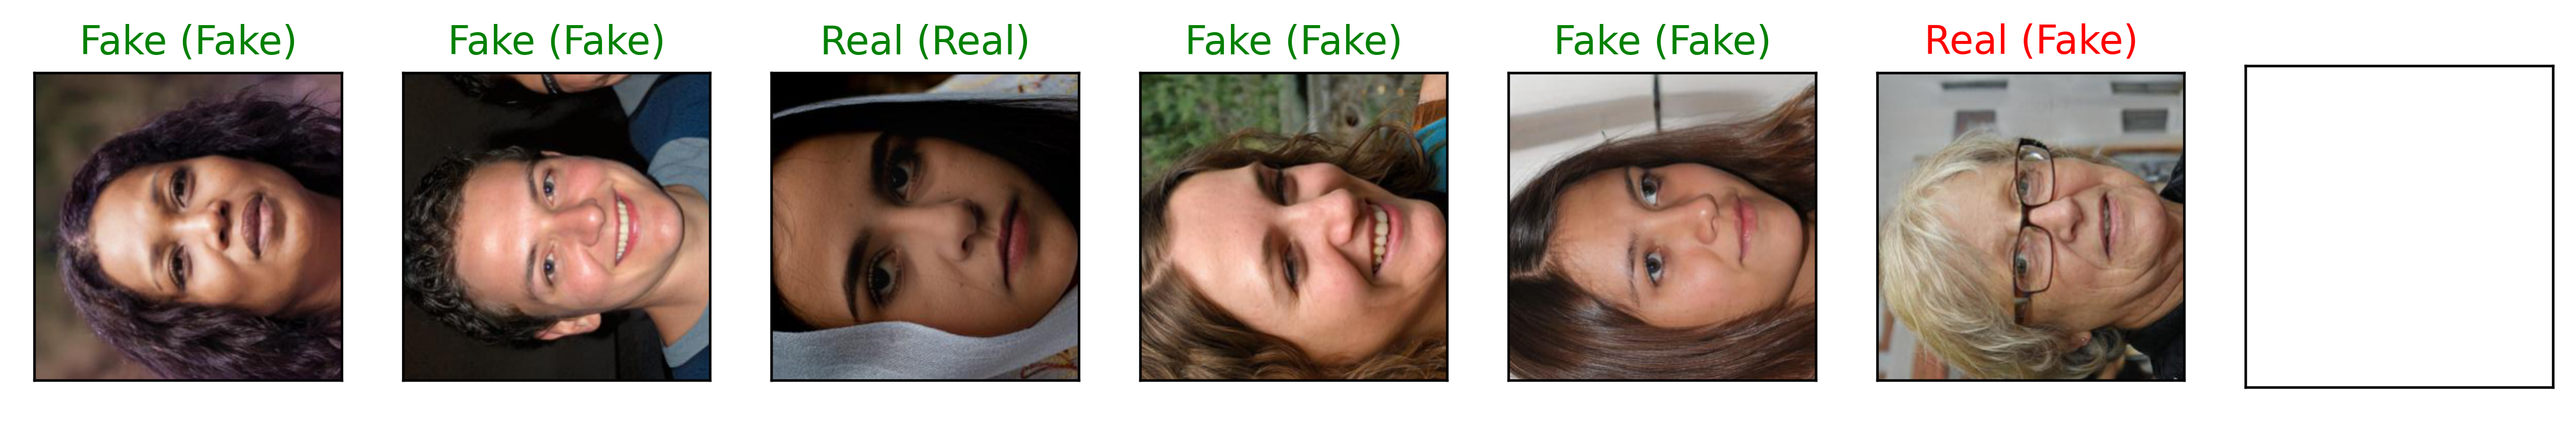

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
labels = labels.numpy()
print(images.shape)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.swapaxes((images[idx]),axis1=0, axis2=2))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if classes[preds[idx]]==classes[labels[idx]] else "red"))
    
plt.savefig('Xception_mis.pdf')